In [28]:
#what are we running?
import sys
print(sys.version)

3.8.7 (tags/v3.8.7:6503f05, Dec 21 2020, 17:59:51) [MSC v.1928 64 bit (AMD64)]


In [30]:
import html
import unidecode

def decode2(s):
  t = unidecode.unidecode(s)
  if (t == '[?]'): 
    return '_'
  else:
    return(t)

def decodeStr(s):
    t =""
    for x in s:
      t = t+decode2(x)
    return t


def clean_work(s):
    s = html.unescape(s)
    s = decodeStr(s)  #convert foreign language to bad-english
    skips = re.compile(r"[^\x00-\x7F]")  #get rid of anything non-ascii
    s = re.sub(skips," ",s)
    s = re.sub('  ',' ',s)
    s = s.replace('\t',' ')
    s = s.replace('\n',' ')
    s = s.replace("'"," ")  #get rid of single quotes
    s = s.replace('"',' ')  #get rid of double quotes
    s = s.replace('  ',' ') #get rid of extra spaces
    return(s.strip())

def clean17(s):
    s=clean_work(s)
    t=clean_work(s)
    while(s!=t):
        s=t
        t=clean_work(s)
    return(s)

def left(s, amount):
    return s[:amount]

def right(s, amount):
    return s[-amount:]

def isRetweet(tweet):
    return (left(tweet,3)=='rt ')

## Vince Purcell - Data Warehousing - Fall21 - HW1
All the functions above are from Professor Brietzmans SampleDataPipeline.ipynb

## Homework
I've given you all of the tools you need. Finish the pipeline as follows:
<br>
1. Rebuild the table after standardizing the date-time in YYYY-MM-DD HH:MM format.
<br>
2. Pick two time periods at least 30 minutes apart and write a function that takes the 2 time periods (low and high) and returns all tweets in the table between those time periods.  Your function should contain SQL code, so don't do outside of the database.
<br>
3. Collect all the hashtags (e.g. #metoo) within any 1 hour period and display a frequency distribution similar to what was done with handles above.  If you're not using the function from 2. then you are doing something wrong.
<br>
4. Repeat step 3.  First time do it with SQL and the second time do it with a Python dictionary or a Java hashmap.  (Google it if necessary)                  
<br>
5. Use https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm to create a bar chart for 4. above using matplotlib. (or do something fancier if you prefer).
<br>

## Rules of the game.
I don't care if you work with someone else.  You should cite each other and each turn in your own submission.
<br>
I don't care if you use SQLite, mySQL, Oracle, Access, whatever.  Use anything you want, as long as you call it from a language.
<br>
I don't care if you use Python, Java, Haskell, whatever.  If you want to be a data engineer one day though, you should start using Python.
<br>
If you use Jupyter notebook then save as an html file and hand in both HTMl file and .ipynb file.  If you use an IDE or some other language send me source code as well as output in a text file.
<br>
Have fun; don't stress out.  This is pretty easy actually.

            


In [34]:
import sqlite3 as lite
month_dict = {
    'Jan' : '01',
    'Feb' : '02',
    'Mar' : '03',
    'Apr' : '04',
    'May' : '05',
    'Jun' : '06',
    'Jul' : '07',
    'Aug' : '08',
    'Sep' : '09',
    'Oct' : '10',
    'Nov' : '11',
    'Dec' : '12'
}

In [ ]:
def standardDate(date_str):
    date_split = date_str.split()
    date = date_split[5] + "-" + month_dict[date_split[1]] + "-" + date_split[2]
    time = date_split[3].split(":")[0] + ":" + date_split[3].split(":")[1]
    return(date + " " + time)

input_date = 
print("This is a test")

### Homework Part 1 ###

In [35]:
con = lite.connect(r'tweets.db')  #we'll create a physical database because we're in DW, but for 
                                  #50,000 tweets we could create this in memory. Google it!
cur = con.cursor()
#create a tweets table
cur.execute('drop table if exists tweets')
cur.execute('create Table tweets(date1 TEXT, tweetID TEXT, Tweet TEXT, handle TEXT, isRetweet INT)')

with open(r'randomTweets.txt') as csv_file: 
    csv_reader = csv.reader(csv_file, delimiter='\t')
    for i,row in enumerate(csv_reader):
            date = standardDate(row[0])
            tweetID = row[1]
            tweet = clean17(row[2]).lower()
            handle = row[4]
            if (isRetweet(tweet)):
                isRT = 1
            else:
                isRT = 0
            if ((i % 20000)==0):
                con.commit()
                print('committing row '+str(i))
            try:
              cur.execute("INSERT INTO tweets VALUES (?,?,?,?,?)",
                          (date,tweetID,tweet,handle,isRT))
            except lite.OperationalError as err:
                 print("insert error: %s", err)
                 break
 

print(i,' rows in file')
con.commit()
con.close()

committing row 0
committing row 20000
committing row 40000
50025  rows in file


### Homework Part 2 ###
##### Wrote functions for datetime and time #####

In [36]:
# Takes connection and low/high date time range
# (YYYY-MM-DD HH:MM)
def selectTweetsFromDateTimeRange(con, low, high):
    cur = con.cursor()
    cur.execute("SELECT * FROM tweets WHERE STRFTIME('%Y-%m-%d %H:%M',date1) >= ? AND STRFTIME('%Y-%m-%d %H:%M',date1) <= ?", (low,high))
    return cur

# Takes time in following format: HH:MM
def selectTweetsFromTimeRange(con, low, high):
    cur = con.cursor()
    cur.execute("SELECT * FROM tweets WHERE STRFTIME('%H:%M',date1) >= ? AND STRFTIME('%H:%M',date1) <= ?", (low,high))
    return cur

### Homework Part 3 ###
##### Create Hashtag Table #####

In [37]:
con = lite.connect(r'tweets.db')

time_cur = selectTweetsFromTimeRange(con, "05:00", "06:00")
rows = time_cur.fetchall()

cur = con.cursor()

cur.execute('drop table if exists hashtags')
cur.execute('create Table hashtags(tweetID TEXT, hashtag TEXT)')

count = 1
for row in rows:
    tweet = row[2]
    tweetID = row[1]
    for word in tweet.split():
        if word[0] == "#" and len(word)>1:
            hashtag = word
            if ((count % 20000)==0):
                con.commit()
                print('committing row '+str(count))
            try:
                cur.execute("INSERT INTO hashtags VALUES (?,?)",
                            (tweetID, hashtag))
                count = count + 1
            except lite.OperationalError as err:
                    print("insert error: %s", err)
                    break

con.commit()
print('committing row '+str(count))
con.close()

committing row 935


### Homework Part 3 ###
##### Count hashtags #####

In [38]:
con = lite.connect(r'tweets.db')
cur = con.cursor()
s = 'select count(hashtag) as cnt1, hashtag from hashtags group by hashtag order by cnt1 DESC limit 20'
cur.execute(s)
rows = cur.fetchall()
for row in rows:
    print(row)
con.close()

(37, '#mtvhottest')
(24, '#1')
(15, '#wayv')
(13, '#dilbechara')
(10, '#folklore')
(10, '#blacklivesmatter')
(10, '#arashisummer')
(9, '#__2')
(8, '#inthesummer')
(8, '#covid19')
(8, '#blackpink')
(7, '#arashi')
(7, '#allstars5')
(7, '#6yearsofvikramadithyan')
(6, '#3')
(6, '#2')
(5, '#truehumanitywarriors')
(5, '#portland')
(5, '#bts')
(5, '#americasgreatestmistake')


### Homework part 4 ###

In [39]:
con = lite.connect(r'tweets.db')

time_cur = selectTweetsFromTimeRange(con, "05:00", "06:00")

rows = time_cur.fetchall()

hashtags = {}

for row in rows:
    tweet = row[2]
    words = tweet.split()
    for word in words:
        if word[0] == "#" and len(word)>1:
            if word in hashtags:
                hashtags[word] = hashtags[word] + 1
            else:
                hashtags[word] = 1

tuples = sorted(hashtags.items(), reverse=True, key=lambda x: x[1])

top_25_hashtags = {}
count = 0
for hashtag in tuples :
    print(hashtag[0] , " : " , hashtag[1] )
    top_25_hashtags[hashtag[0]] = hashtag[1]
    if count == 25:
        break
    count = count + 1 

con.close()

#mtvhottest  :  37
#1  :  24
#wayv  :  15
#dilbechara  :  13
#arashisummer  :  10
#blacklivesmatter  :  10
#folklore  :  10
#__2  :  9
#inthesummer  :  8
#covid19  :  8
#blackpink  :  8
#arashi  :  7
#6yearsofvikramadithyan  :  7
#allstars5  :  7
#3  :  6
#2  :  6
#truehumanitywarriors  :  5
#4  :  5
#bts  :  5
#portland  :  5
#americasgreatestmistake  :  5
#ripbernelltremmell  :  4
#okasia  :  4
#5  :  4
#zepeto  :  4
#blackpinkhouse  :  4


### Homework Part 5 ###

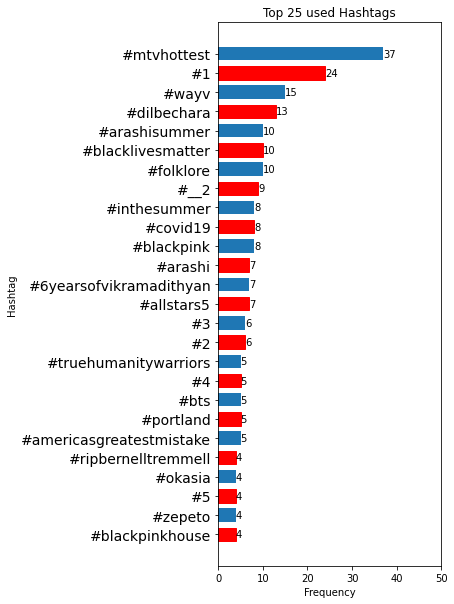

In [40]:
import matplotlib.pyplot as plt

# Modified Code from
# https://towardsdatascience.com/how-to-make-bar-and-hbar-charts-with-labels-using-matplotlib-b701ce70ba9c

fig, ax = plt.subplots(figsize=(4, 10))
bars = ax.barh(*zip(*top_25_hashtags.items().__reversed__()), 0.7)
for bar in bars:
  width = bar.get_width()
  label_y_pos = bar.get_y() + bar.get_height() / 2
  ax.text(width, label_y_pos, s=f'{width}', va='center')
for tick in ax.yaxis.get_major_ticks():
  tick.label.set_fontsize(14)
for bar in bars[::2]:
  bar.set_color('r')
plt.title('Top 25 used Hashtags')
plt.xlabel('Frequency')
plt.ylabel('Hashtag')
plt.xlim([0,50])
plt.show()